<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# Quantifying river channel evolution with Landlab
These exercises are based on a project orginally designed by Kelin Whipple at Arizona State University. This notebook was created by Nicole Gasparini at Tulane University.

<hr>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

**What is this notebook?**

This notebook illustrates the evolution of detachment-limited channels in an actively uplifting landscape. The landscape evolves according to the equation:

\begin{equation}
 \frac{d z}{d t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + U
\end{equation}
Here, $K_{sp}$ is the erodibility coefficient on fluvial incision, which is thought to be positively correlated with climate wetness, or storminess (this is hard to quantify) and to be negatively correlated with rock strength (again, rock strength is hard to quantify). $m_{sp}$ and $n_{sp}$ are positive exponents, usually thought to have a ratio, $m_{sp}/n_{sp} \approx 0.5$. $A$ is drainage area and $S$ is the slope of steepest descent ($-\frac{dz}{dx}$) where $x$ is horizontal distance (positive in the downslope direction) and $z$ is elevation. (If slope is negative there is no fluvial erosion.) $U$ is an externally-applied rock uplift field.

The fluvial erosion term is also known as the stream power equation. Before using this notebook you should be familiar with this equation from class lectures and reading. 

For a great overview of the stream power equation, see: 

- Whipple and Tucker, 1999, Dynamics of the stream-power river incision model: Implications for height limits of mountain ranges, landscape response timescales, and research needs, Journal of Geophysical Research.

For some great illustrations of modeling with the sream power equation, see:

- Tucker and Whipple, 2002, Topographic outcomes predicted by stream erosion models: Sensitivity analysis and intermodel comparison, Journal of Geophysical Research.

Helpful background on landscape sensitivity to rock uplift rates and patterns can be found here:

- Kirby and Whipple, 2012, Expression of active tectonics in erosional landscapes, Journal of Structural Geology.

**What will you do?**

In this exercise you will modify the code to get a better understanding of how rock uplift rates and patterns and the erodibility coefficient control fluvial channel form.

Start at the top by reading each block of text and sequentially running each code block (shift - enter OR got to the _Cell_ pulldown menu at the top and choose _Run Cells_). 

If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. (E.g. if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.) 

**STUDENTS: Questions to answer before starting this assignment.**

Answer these questions before running the notebook.

1. What do you think will happen to total relief (defined as the maximum minus the minimum elevation, here area is fixed) and channel slope at steady state if $K_{sp}$ is uniformly increased?
2. What do you think will happen to total relief and channel slope at steady state if $U$ is uniformly increased?
3. How do you think a steady-state landscape with a uniform low rock uplift rate will respond if rock uplift is uniformly increased (relative to a steady base level)? How will channel slopes change through time?

**Now on to the code...**

First we have to import the parts of Python and Landlab that are needed to run this code. You should not have to change this first code block.

In [10]:
# Code block 1

import copy

import numpy as np
from matplotlib import pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
)
from landlab.io import write_esri_ascii

Make a grid and set boundary conditions. 

In [11]:
# Code Block 2

number_of_rows = 50  # number of raster cells in vertical direction (y)
number_of_columns = 100  # number of raster cells in horizontal direction (x)
dxy = 200  # side length of a raster model cell, or resolution [m]

# Below is a raster (square cells) grid, with equal width and height
mg1 = RasterModelGrid((number_of_rows, number_of_columns), dxy)

# Set boundary conditions - only the south side of the grid is open.
# Boolean parameters are sent to function in order of
# east, north, west, south.
mg1.set_closed_boundaries_at_grid_edges(True, True, True, False)

Here we make the initial grid of elevation of zeros with a very small amount of noise to make a more pleasing network.

In [12]:
# Code Block 3

np.random.seed(35)  # seed set so our figures are reproducible
mg1_noise = (np.random.rand(mg1.number_of_nodes) / 1000.0
             )  # intial noise on elevation gri

# set up the elevation on the grid
z1 = mg1.add_zeros("topographic__elevation", at="node")
z1 += mg1_noise

Set parameters related to time.

In [13]:
# Code Block 4

tmax = 5e5  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 1000  # time step [yr] (Original value was 100 yr)
total_time = 0  # amount of time the landscape has evolved [yr]
# total_time will increase as you keep running the code.

t = np.arange(0, tmax, dt)  # each of the time steps that the code will run

In [5]:
#AL's code block for printing, etc.
#print(t)
#mg1.number_of_node_columns
#mg1.number_of_node_rows

Set parameters for incision and intializing all of the process components that do the work. We also initialize tools for quantifying the landscape.

In [14]:
# Code Block 5

# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

frr = FlowAccumulator(mg1)  # intializing flow routing
spr = StreamPowerEroder(mg1, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp,
                        threshold_sp=0.0)  # initializing stream power incision

theta = m_sp / n_sp
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg1, reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg1,
               min_drainage_area=1000.0,
               reference_concavity=theta,
               use_true_dx=True)

Initialize rock uplift rate. This will need to be changed later.

In [15]:
# Code Block 6

#  uplift_rate [m/yr] (Original value is 0.0001 m/yr)
uplift_rate = np.ones(mg1.number_of_nodes) * 0.0001

Now for the code loop. 

Note that you can rerun Code Block 7 many times, and as long as you don't reset the elevation field (Code Block 3), it will take the already evolved landscape and evolve it even more. If you want to change parameters in other code blocks (e.g. Code Block 5 or 6), you can do that too, and as long as you don't reset the elevation field (Code Block 3) the new parameters will apply on the already evolved topography. 

In [16]:
# Code Block 7

for ti in t:
    z1[mg1.
       core_nodes] += uplift_rate[mg1.core_nodes] * dt  # uplift the landscape
    frr.run_one_step()  # route flow
    spr.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    #print(total_time)

Plot the topography.

Maximum elevation is  50.0001680512


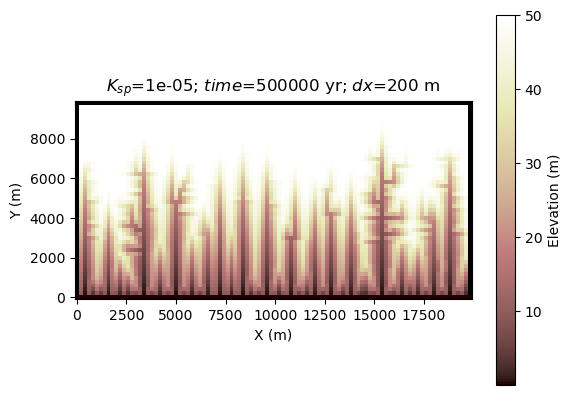

In [17]:
# Code Block 8

imshow_grid(mg1,
            "topographic__elevation",
            grid_units=("m", "m"),
            var_name="Elevation (m)")
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)

max_elev = np.max(z1)
print("Maximum elevation is ", np.max(z1))

Plot the slope and area data at each point on the landscape (in log-log space). We will only plot the core nodes because the boundary nodes have slopes that are influenced by the boundary conditions. 

In [ ]:
# Code Block 9

plt.loglog(
    mg1.at_node["drainage_area"][mg1.core_nodes],
    mg1.at_node["topographic__steepest_slope"][mg1.core_nodes],
    "b.",
)
plt.ylabel("Topographic slope")
plt.xlabel("Drainage area (m^2)")
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"

plt.title(title_text)

It is slightly easier to interpret slope-area data when we look at a single channel, rather than the entire landscape. Below we plot the profile and slope-area data for the three largest channels on the landscape.

In [ ]:
# Code Block 10

# profile the largest channels, set initially to find the mainstem channel in the three biggest watersheds
# you can change the number of watersheds, or choose to plot all the channel segments in the watershed that
# have drainage area below the threshold (here we have set the threshold to the area of a grid cell).
prf = ChannelProfiler(mg1,
                      number_of_watersheds=3,
                      main_channel_only=True,
                      minimum_channel_threshold=dxy**2)
prf.run_one_step()

# plot the elevation as a function of distance upstream
plt.figure(1)
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)

# plot the location of the channels in map view
plt.figure(2)
prf.plot_profiles_in_map_view()

# slope-area data in just the profiled channels
plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg1.at_node["drainage_area"][profile_ids],
            mg1.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)

The chi index is a useful way to quantitatively interpret fluvial channels. Below we plot the chi index in the three largest channels and also a chi map across the entire landscape. 

In [ ]:
# Code Block 11

# calculate the chi index
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(4)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg1.at_node["channel__chi_index"][profile_ids],
            mg1.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
plt.title(title_text)

# chi map
plt.figure(5)
imshow_grid(
    mg1,
    "channel__chi_index",
    grid_units=("m", "m"),
    var_name="Chi index (m)",
    cmap="jet",
)
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
plt.title(title_text)

The channel steepness index is another useful index to quantify fluvial channels. Below we plot the steepness index in the same three largest channels, and also plot steepness index across the grid.

In [ ]:
# Code Block 12

# calculate channel steepness
sf.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(6)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg1.at_node["channel__steepness_index"][profile_ids],
            'x',
            color=color,
            label=label,
        )

plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
plt.title(
    f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
)

# channel steepness map
plt.figure(7)
imshow_grid(
    mg1,
    "channel__steepness_index",
    grid_units=("m", "m"),
    var_name="Steepness index ",
    cmap="jet",
)
title_text = ("$K_{sp}$=" + str(K_sp) + "; $time$=" + str(total_time) +
              "yr; $dx$=" + str(dxy) + "m" + "; concavity=" + str(theta))
plt.title(
    f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
)

If you have a grid that you want to export, uncomment and edit the appropriate lines below and run the code block.

In [ ]:
# Code Block 13

## Below has the name of the file that data will be written to.
## You need to change the name of the file every time that you want
## to write data, otherwise you will get an error.
## This will write to the directory that you are running the code in.
# write_file_name = 'data_file.txt'
## Below is writing elevation data in the ESRI ascii format so that it can
## easily be read into Arc GIS or back into Landlab.
# write_esri_ascii(write_file_name, mg1, 'topographic__elevation')

After running every code block once, has the landscape reached steady state? Answer: NO! How do you know? After you think about this, you are ready to complete this project.

Answer the following questions using the code above and below. All answers should be typed, and supporting figures (produced using the code) should be embedded in one document that you hand in. Code Blocks 8-12 and 18-21 produce different figures that you may find useful. You can use any or all of these different figures to help you with the questions below. (Download or screenshoot the figures.) 

Anything with a question mark should be answered in the document that you hand in. Make sure your write in full sentences and proofread the document that you hand in.

1. **Steady state with low uplift rate. ** Using the parameters provided in the initial notebook, run the landscape to steady state. (Note that you can keep running the main evolution loop - Code Block 7 - and the different plotting blocks without running the code blocks above them. You may also want to change $tmax$ in Code Block 4.) How did you know that the landscape reached steady state? Note the approximate time that it took to reach steady state for your own reference. (This will be usefull for later questions.) Include appropriate plots. (If you want to analyze these landscapes outside of Landlab or save for later, make sure you save the elevation data to a text file (Code Block 13).)

** NOTE, For the rest of the questions you should use Code Blocks 14 - 21. These will allow you to use the steady-state landscape created for question 1 - referred to here as the 'base landscape' - as the initial condition. Start by editing what you need to in Code Blocks 14 - 16. Run these each once, sequentially. You can run Code Block 17, the time loop, as many times as you need to, along with Code Blocks 18-21, which produce plots.**

2. **Transient landscape responding to an increase in rock uplift. ** Use the base landscape and increase rock uplift uniformly by a factor of 4 to 0.0004 m/yr. Make sure you update the rock uplift rate (Code Block 16) and ensure that $tmax$ is 1e5 yrs and $dt$ is 500 yrs (Code Block 15). Run this until the maximum elevation in the grid is ~ 170 m and observe how the landscape gets to this elevation, i.e. plot intermediate steps. What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a landscape response to uniform increase in rock uplift rate? (You may need to answer this after completing all of the questions.)

3. ** Steady-state landscape with increased rock uplift. ** Now run the landscape from question 2 until it reaches steady state. (I.e. run the time loop, Code Block 17, a bunch of times. You can increase $tmax$ and $dt$ to make this run faster.) Provide a plot that illustrates that the landscape is in steady state. What aspects of the landscape have changed in comparison with the base landscape from question 1?

4. ** Increase erodibility. ** Start again from the base landscape, but this time increase $K_{sp}$ to 2E-5 (Code Block 14). Make sure rock uplift rate is set to the original value of 0.0001 m/yr (Code Block 16). Set $tmax$ to 1e5 yrs (Code Block 15). Run for 1e5 yrs and save the plots that you think are diagnostic. Run for another 1e5 yrs and save plots again. Now run for 5e5 yrs and save plots again. Quantitatively describe how the landscape evolves in response to the increase in erodibility and provide supporting plots. What could cause a uniform increase in erodibility?

5. ** Spatially varible uplift - discrete, massive earthquake. ** Start again from the base landscape, and make sure that $K_{sp}$ = 1E-5 (Code Block 14). Now add a seismic event to this steady state landscape - a fault that runs horizontally across the landscape at y = 4000 m, and instantaneously uplifts half the landscape by 10 meters (Code Block 16). In this case, we will keep background uplift uniform at 0.0001 m/yr. Set $tmax$ to 1e5 yrs and $dt$ to 500 yrs (Code Block 15) before evolving the landscape after the fault. Now run the time loop four times and look at the different plots after each loop. How does the landscape respond to this fault? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to an earthquake? (You may need to answer this after completing all of the questions.)

6. ** Spatially Varible Rock Uplift - discrete fault with two different uplift rates. ** Start again from the base landscape, and make sure that $K_{sp}$ = 1E-5 (Code Block 14). Now we will add a fault (at y = 4000 m) to this landscape. In this case the uplift rate on the footwall is higher (0.0004 m/yr) than on the hanging wall (uplift rate = 0.0001 m/yr). (Edit Code Block 16.) Set $tmax$ to 1e5 yrs and $dt$ to 500 yrs (Code Block 15). Now run the time loop four separate times and look at the different plots after each loop. How does the landscape respond to this fault? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to a this type of gradient in rock uplift rates? (You may need to answer this after completing all of the questions.)

7. ** Spatially Varible Rock Uplift - gradient in uplift across the range. ** Start again from the base landscape, and make sure that $K_{sp}$ = 1E-5 (Code Block 14). Now we will add a linear gradient in uplift rate across the entire range (edit Code Block 16). The maximum uplift rate will be 0.0004 m/yr at the core of the range, and 0.0001 m/yr at the front of the range. Set $tmax$ to 1e5 yrs (Code Block 4) and $dt$ to 500 yrs before you start running the time loop for the fault before you start running the time loop with the rock uplift gradient. Now run the time loop four separate times and look at the different plots after each loop. How does the landscape respond to this gradient in uplift rate? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to this type of gradient in rock uplift rates? (You may need to answer this after completing all of the questions.)

8. ** Final Reflection. ** Was your initial insight into how parameters would affect the landscape correct? Discuss in 6 sentences or less.

In [ ]:
# Code Block 14

number_of_rows = 50  # number of raster cells in vertical direction (y)
number_of_columns = 100  # number of raster cells in horizontal direction (x)
dxy2 = 200  # side length of a raster model cell, or resolution [m]

# Below is a raster (square cells) grid, with equal width and height
mg2 = RasterModelGrid((number_of_rows, number_of_columns), dxy2)

# Set boundary conditions - only the south side of the grid is open.
# Boolean parameters are sent to function in order of
# east, north, west, south.
mg2.set_closed_boundaries_at_grid_edges(True, True, True, False)

z2 = copy.copy(z1)  # initialize the elevations with the steady state
# topography produced for question 1
z2 = mg2.add_field("topographic__elevation", z2, at="node")

# K_sp value for base landscape is 1e-5
K_sp2 = 2e-5  # units vary depending on m_sp and n_sp
m_sp2 = 0.5  # exponent on drainage area in stream power equation
n_sp2 = 1.0  # exponent on slope in stream power equation

frr2 = FlowAccumulator(mg2)  # intializing flow routing
spr2 = StreamPowerEroder(
    mg2, K_sp=K_sp2, m_sp=m_sp2, n_sp=n_sp2,
    threshold_sp=0.0)  # initializing stream power incision

theta2 = m_sp2 / n_sp2
# initialize the component that will calculate channel steepness
sf2 = SteepnessFinder(mg2,
                      reference_concavity=theta2,
                      min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf2 = ChiFinder(mg2,
                min_drainage_area=1000.0,
                reference_concavity=theta2,
                use_true_dx=True)

In [ ]:
# Code Block 15

tmax = 1e5  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 500  # time step [yr] (Original value was 500 yr)
total_time = 0  # amount of time the landscape has evolved [yr]
# total_time will increase as you keep running the code.

t = np.arange(0, tmax, dt)  # each of the time steps that the code will run

In [ ]:
# Code Block 16

#  uplift_rate [m/yr] (value was 0.0001 m/yr for base landscape)
uplift_rate = np.ones(mg2.number_of_nodes) * 0.0001

## If you want to add a one-time event that uplifts only part of the
## landscape, uncomment the 3 lines below
# fault_location = 4000  # [m]
# uplift_amount = 10 # [m]
# z2[np.nonzero(mg2.node_y>fault_location)] += uplift_amount

## IMPORTANT! To use the below fault generator, comment the one-time
## uplift event above if it isn't already commented out.
## Code below creates a fault horizontally across the grid.
## Uplift rates are greater where y values  > fault location.
## To use, uncomment the 5 code lines below and edit to your values
# fault_location = 4000  # [m]
# low_uplift_rate = 0.0001 # [m/yr]
# high_uplift_rate = 0.0004 # [m/yr]
# uplift_rate[np.nonzero(mg2.node_y<fault_location)] = low_uplift_rate
# uplift_rate[np.nonzero(mg2.node_y>fault_location)] = high_uplift_rate

## IMPORTANT! To use below rock uplift gradient, comment the two
## uplift options above if they aren't already commented out.
## If you want a linear gradient in uplift rate
## (increasing uplift into the range),
## uncomment the 4 code lines below and edit to your values.
# low_uplift_rate = 0.0001 # [m/yr]
# high_uplift_rate = 0.0004 # [m/yr]
## below is uplift gradient per node row index, NOT row value in meters
# uplift_rate_gradient = (high_uplift_rate - low_uplift_rate)/(number_of_rows-3)
# uplift_rate = low_uplift_rate + ((mg2.node_y / dxy)-1) * uplift_rate_gradient

In [ ]:
# Code Block 17

for ti in t:
    z2[mg1.
       core_nodes] += uplift_rate[mg2.core_nodes] * dt  # uplift the landscape
    frr2.run_one_step()  # route flow
    spr2.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    print(total_time)

In [ ]:
# Code Block 18
# Plot topography

plt.figure(8)
imshow_grid(mg2,
            "topographic__elevation",
            grid_units=("m", "m"),
            var_name="Elevation (m)")
plt.title(f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m")

max_elev = np.max(z2)
print("Maximum elevation is ", np.max(z2))

In [ ]:
# Code Block 19
# Plot Channel Profiles and slope-area data along the channels

prf2 = ChannelProfiler(mg2,
                       number_of_watersheds=3,
                       main_channel_only=True,
                       minimum_channel_threshold=dxy**2)
prf2.run_one_step()

# plot the elevation as a function of distance upstream
plt.figure(9)
title_text = f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)

# plot the location of the channels in map view
plt.figure(10)
prf2.plot_profiles_in_map_view()

# slope-area data in just the profiled channels
plt.figure(11)
for i, outlet_id in enumerate(prf2.data_structure):
    for j, segment_id in enumerate(prf2.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf2.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg2.at_node["drainage_area"][profile_ids],
            mg2.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m"
plt.title(title_text)

In [ ]:
# Code Block 20
# Chi Plots

# calculate the chi index
cf2.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(12)
for i, outlet_id in enumerate(prf2.data_structure):
    for j, segment_id in enumerate(prf2.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf2.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg2.at_node["channel__chi_index"][profile_ids],
            mg2.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
plt.title(title_text)

# chi map
plt.figure(13)
imshow_grid(
    mg2,
    "channel__chi_index",
    grid_units=("m", "m"),
    var_name="Chi index (m)",
    cmap="jet",
)
plt.title(
    f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
)

In [ ]:
# Code Block 21
# Plot channel steepness along profiles and across the landscape

# calculate channel steepness
sf2.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(14)

for i, outlet_id in enumerate(prf2.data_structure):
    for j, segment_id in enumerate(prf2.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf2.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg2.at_node["channel__steepness_index"][profile_ids],
            'x',
            color=color,
            label=label,
        )

plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
plt.title(
    f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
)

# channel steepness map
plt.figure(15)
imshow_grid(
    mg2,
    "channel__steepness_index",
    grid_units=("m", "m"),
    var_name="Steepness index ",
    cmap="jet",
)
plt.title(
    f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
)